In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
from sklearn.metrics.cluster import normalized_mutual_info_score

Flags

In [11]:
SAVE_TO_CSV = False

Prepare data

In [2]:
# Load movie-to-movie relation graph
graph_file_path = 'data/community/jaccard_backboned.csv'
graph_data = pd.read_csv(graph_file_path)

# Load movie metadata
metadata_file_path = 'data/transformed/item_metadata.json'
metadata_data = pd.read_json(metadata_file_path, orient='index')
metadata_data.reset_index(inplace=True)
metadata_data.columns = ['movie_id', 'title', 'release_date'] + list(metadata_data.columns[3:])

# Prepare graph for algorithms
G = nx.Graph()
for index, row in graph_data.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['nij'])

G.number_of_nodes(), G.number_of_edges()


(1682, 54394)

In [3]:
# Create ground truth labels from genres
genre_columns = ['Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
                 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
metadata_data['genre_label'] = metadata_data[genre_columns].apply(lambda row: ','.join(row.index[row == 1]), axis=1)

# Convert genre labels to codes for NMI calculation
true_labels = metadata_data['genre_label'].astype('category').cat.codes

Label Propagation

In [4]:
def communities_to_labels(communities, num_nodes):
    labels = [0] * num_nodes
    for i, community in enumerate(communities):
        for node in community:
            labels[int(node[1:]) - 1] = i
    return labels

In [5]:
# Save communities to CSV file
def save_communities_to_csv(communities, file_path):
    community_labels = []
    for i, community in enumerate(communities):
        for node in community:
            community_labels.append((node, i))
    community_df = pd.DataFrame(community_labels, columns=['movie_id', 'community_label'])
    community_df.to_csv(file_path, index=False)

In [7]:
# Run Label Propagation with seed for reproducibility
communities_label_propagation = community.asyn_lpa_communities(G, seed=42)
communities_label_propagation = [list(c) for c in communities_label_propagation]

if SAVE_TO_CSV:
    save_communities_to_csv(communities_label_propagation, 'data/community/communities_label_propagation.csv')

# Predicted labels from Label Propagation
predicted_labels_label_propagation = communities_to_labels(communities_label_propagation, G.number_of_nodes())

# Calculate NMI for Label Propagation
nmi_label_propagation = normalized_mutual_info_score(true_labels, predicted_labels_label_propagation)

nmi_label_propagation

c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0.10500113350172598

Visualization

In [19]:
# Visualize communities
def visualize_communities(G, communities):
    # Filter edges to only show those with high weights
    threshold = 0.25
    filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > threshold]
    filtered_G = nx.Graph(filtered_edges)
    
    # Get positions for the nodes in G
    pos = nx.spring_layout(filtered_G, k=0.3, iterations=50)
    
    # Generate a unique color for each community
    colors = [plt.cm.nipy_spectral(i / len(communities)) for i in range(len(communities))]
    
    # Create a color map for the nodes
    node_colors = {}
    for i, community in enumerate(communities):
        for node in community:
            if node not in node_colors:
                node_colors[node] = colors[i]
    
    # Draw the graphs
    nx.draw(filtered_G, pos, with_labels=False, node_size=15, edge_color="lightgrey", node_color=[node_colors.get(node, 'grey') for node in filtered_G.nodes()])
    
    # Show the plot
    plt.show()


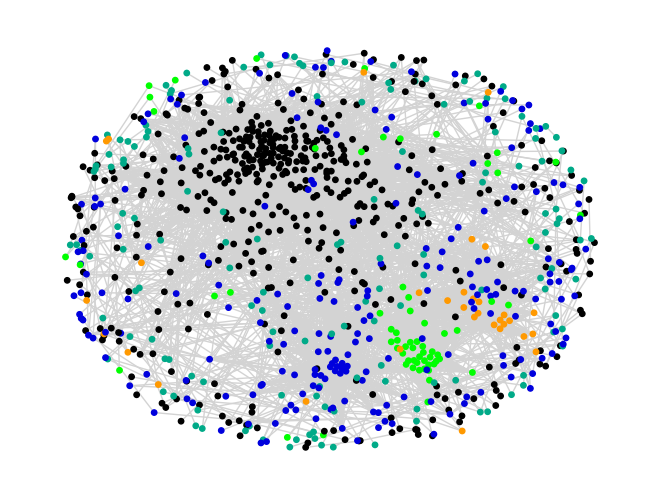

In [20]:
# Load movie-to-movie relation graph
graph_file_path = 'data/community/jaccard_backboned.csv'
graph_data = pd.read_csv(graph_file_path)

# Load communities
communities_file_path = 'data/community/communities_label_propagation.csv'
communities_data = pd.read_csv(communities_file_path)

# Prepare graph for visualization
G = nx.Graph()
for index, row in graph_data.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['nij'])

# Convert communities data to list of lists
communities = communities_data.groupby('community_label')['movie_id'].apply(list).tolist()

visualize_communities(G, communities)

DEMON

In [12]:
import demon as d

# Load movie-to-movie relation graph
graph_file_path = 'data/community/jaccard_backboned.csv'
graph_data = pd.read_csv(graph_file_path)

# Load movie metadata
metadata_file_path = 'data/transformed/item_metadata.json'
metadata_data = pd.read_json(metadata_file_path, orient='index')
metadata_data.reset_index(inplace=True)
metadata_data.columns = ['movie_id', 'title', 'release_date'] + list(metadata_data.columns[3:])

# Prepare graph for algorithms
G = nx.Graph()
for index, row in graph_data.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['nij'])

# Create a Demon instance with a given resolution parameter
demon = d.Demon(graph=G, min_community_size=3)

# Execute the algorithm
communities_demon = demon.execute()

# Save communities to CSV file
if SAVE_TO_CSV:
# if True:
    save_communities_to_csv(communities_demon, 'data/community/communities_demon.csv')

Exec: 100%|████████████████████████

Time:  'execute' 31.62 sec
------------------------------------


In [22]:
# Predicted labels from DEMON
predicted_labels_demon = communities_to_labels(communities_demon, G.number_of_nodes())

# Calculate NMI for Label Propagation
nmi_demon = normalized_mutual_info_score(true_labels, predicted_labels_demon)

nmi_demon

0.07563587098155304

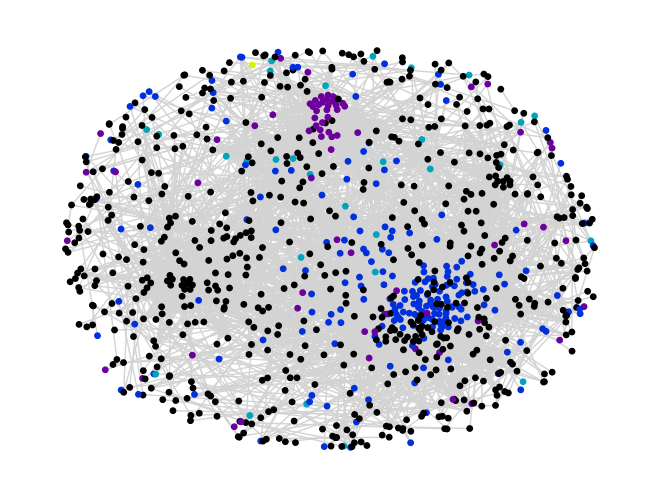

In [21]:
# Load movie-to-movie relation graph
graph_file_path = 'data/community/jaccard_backboned.csv'
graph_data = pd.read_csv(graph_file_path)

# Load communities
communities_file_path = 'data/community/communities_demon.csv'
communities_data = pd.read_csv(communities_file_path)

# Prepare graph for visualization
G = nx.Graph()
for index, row in graph_data.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['nij'])

# Convert communities data to list of lists
communities = communities_data.groupby('community_label')['movie_id'].apply(list).tolist()

visualize_communities(G, communities)